<a href="https://colab.research.google.com/github/RickStark/Reinforce-Learning-Practice/blob/main/RL_DDPO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import gymnasium as gym
from collections import deque
import random

# Semillas para reproducibilidad
np.random.seed(123)
torch.manual_seed(123)

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)
        return (
            torch.FloatTensor(np.array(state)),
            torch.FloatTensor(np.array(action)),
            torch.FloatTensor(np.array(reward)).unsqueeze(1),
            torch.FloatTensor(np.array(next_state)),
            torch.FloatTensor(np.array(done)).unsqueeze(1)
        )

    def __len__(self):
        return len(self.buffer)

In [2]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()
        self.l1 = nn.Linear(state_dim, 400)
        self.l2 = nn.Linear(400, 300)
        self.l3 = nn.Linear(300, action_dim)
        self.max_action = max_action # Límite de fuerza del motor (ej: 2.0)

    def forward(self, state):
        a = torch.relu(self.l1(state))
        a = torch.relu(self.l2(a))
        # Tanh saca valores entre -1 y 1. Multiplicamos por max_action para escalar.
        return self.max_action * torch.tanh(self.l3(a))

class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        # Entrada: Estado + Acción concatenados
        self.l1 = nn.Linear(state_dim + action_dim, 400)
        self.l2 = nn.Linear(400, 300)
        self.l3 = nn.Linear(300, 1)

    def forward(self, state, action):
        q = torch.cat([state, action], 1) # Concatenación
        q = torch.relu(self.l1(q))
        q = torch.relu(self.l2(q))
        return self.l3(q)

In [3]:
class DDPG_Agent:
    def __init__(self, state_dim, action_dim, max_action):
        self.actor = Actor(state_dim, action_dim, max_action)
        self.actor_target = Actor(state_dim, action_dim, max_action) # Copia lenta
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=1e-3)

        self.critic = Critic(state_dim, action_dim)
        self.critic_target = Critic(state_dim, action_dim) # Copia lenta
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-3)

        self.max_action = max_action
        self.replay_buffer = ReplayBuffer(100000)
        self.criterion = nn.MSELoss()

    def select_action(self, state):
        # Convertir estado a tensor y predecir
        state = torch.FloatTensor(state.reshape(1, -1))
        return self.actor(state).cpu().data.numpy().flatten()

    def train(self, batch_size=64, gamma=0.99, tau=0.005):
        if len(self.replay_buffer) < batch_size:
            return

        # 1. Obtener batch de memoria
        state, action, reward, next_state, done = self.replay_buffer.sample(batch_size)

        # ----------------------
        # Entrenar CRÍTICO
        # ----------------------

        # Calcular el Target Q (lo que esperamos recibir a futuro)
        # Usamos las redes TARGET para esto (estabilidad)
        with torch.no_grad():
            next_action = self.actor_target(next_state)
            target_Q = self.critic_target(next_state, next_action)
            target_Q = reward + (1 - done) * gamma * target_Q

        # Q actual estimada por la red principal
        current_Q = self.critic(state, action)

        # Loss del Crítico
        critic_loss = self.criterion(current_Q, target_Q)

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # ----------------------
        # Entrenar ACTOR
        # ----------------------

        # El actor quiere maximizar el Q que dice el crítico
        # Truco: Maximize Q = Minimize -Q
        actor_loss = -self.critic(state, self.actor(state)).mean()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------
        # Actualizar Redes TARGET (Soft Update)
        # ----------------------
        # Esto mueve los pesos de la red Target muy lentamente hacia la red real
        for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

        for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

In [4]:
env = gym.make("Pendulum-v1") # Render mode opcional si quieres verlo lento
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])

agent = DDPG_Agent(state_dim, action_dim, max_action)

num_episodes = 200
batch_size = 64
noise_std = 0.1 # Ruido para exploración

print("Entrenando DDPG en Pendulum...")
scores = []
for episode in range(num_episodes):
    state, _ = env.reset(seed=123)
    episode_reward = 0
    done = False
    truncated = False

    while not done and not truncated:
        # 1. Elegir acción + RUIDO
        action = agent.select_action(state)
        # Añadir ruido Gaussiano para explorar y cortar para no salir del límite
        noise = np.random.normal(0, max_action * noise_std, size=action_dim)
        action = (action + noise).clip(-max_action, max_action)

        # 2. Ejecutar paso
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        # 3. Guardar en memoria
        # (Truco: Pendulum no tiene 'done' natural por éxito, solo truncated,
        # pero pasamos done=False a la memoria para que no corte el retorno futuro en el cálculo matemático)
        agent.replay_buffer.push(state, action, reward, next_state, False)

        # 4. Entrenar
        agent.train(batch_size=batch_size)

        state = next_state
        episode_reward += reward

    # Reducir ruido a medida que aprendemos
    scores.append(episode_reward)
    if noise_std > 0.01: noise_std *= 0.995

    if episode % 10 == 0:
        print(f"Episode {episode}: Reward {episode_reward:.2f}")

env.close()

Entrenando DDPG en Pendulum...
Episode 0: Reward -1290.92
Episode 10: Reward -1204.65
Episode 20: Reward -780.14
Episode 30: Reward -125.30
Episode 40: Reward -121.25
Episode 50: Reward -121.19
Episode 60: Reward -122.10
Episode 70: Reward -121.70
Episode 80: Reward -121.83
Episode 90: Reward -122.50
Episode 100: Reward -122.94
Episode 110: Reward -123.81
Episode 120: Reward -123.15
Episode 130: Reward -124.37
Episode 140: Reward -127.50
Episode 150: Reward -123.34
Episode 160: Reward -124.66
Episode 170: Reward -123.18
Episode 180: Reward -126.07
Episode 190: Reward -126.89


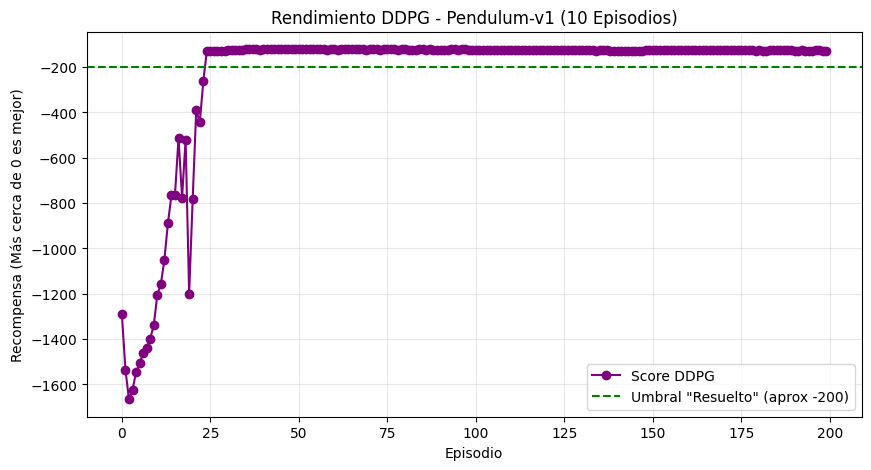

In [6]:
# --- 2. VISUALIZACIÓN GRÁFICA ---
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(scores, marker='o', linestyle='-', color='purple', label='Score DDPG')
plt.axhline(y=-200, color='green', linestyle='--', label='Umbral "Resuelto" (aprox -200)')
plt.title('Rendimiento DDPG - Pendulum-v1 (10 Episodios)')
plt.xlabel('Episodio')
plt.ylabel('Recompensa (Más cerca de 0 es mejor)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [8]:
# Guardar solo los pesos del Actor
torch.save(agent.actor.state_dict(), 'ddpg_pendulum_actor.pth')
print("✅ Modelo del Actor guardado como 'ddpg_pendulum_actor.pth'")

✅ Modelo del Actor guardado como 'ddpg_pendulum_actor.pth'


In [13]:
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import os

# --- 1. DEFINICIÓN DE LA ARQUITECTURA DEL ACTOR ---
# (Debe ser IDÉNTICA a la que usaste para entrenar)
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()
        self.l1 = nn.Linear(state_dim, 400)
        self.l2 = nn.Linear(400, 300)
        self.l3 = nn.Linear(300, action_dim)
        self.max_action = max_action

    def forward(self, state):
        a = torch.relu(self.l1(state))
        a = torch.relu(self.l2(a))
        return self.max_action * torch.tanh(self.l3(a))

# --- 2. CONFIGURACIÓN ---
env_name = "Pendulum-v1"
model_path = "ddpg_pendulum_actor.pth"  # Nombre del archivo guardado
n_episodes = 20

# Crear entorno con grabación de video
# episode_trigger=lambda x: True graba TODOS los episodios
env = gym.make(env_name, render_mode="rgb_array")
#env = RecordVideo(env, video_folder='./video_ddpg_test', episode_trigger=lambda x: True, name_prefix="test-ddpg")

# Obtener dimensiones
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])

# --- 3. CARGAR EL MODELO ---
actor = Actor(state_dim, action_dim, max_action)

if os.path.exists(model_path):
    actor.load_state_dict(torch.load(model_path))
    print(f"✅ Modelo cargado exitosamente desde '{model_path}'")
else:
    print(f"❌ ERROR: No se encontró el archivo '{model_path}'.")
    print("Asegúrate de haber ejecutado el código de guardado primero.")
    exit()

actor.eval() # Poner en modo evaluación

# --- 4. BUCLE DE TEST (20 EPISODIOS) ---
scores = []
print(f"Iniciando prueba de {n_episodes} episodios...")

for i in range(n_episodes):
    state, _ = env.reset()
    done = False
    truncated = False
    score = 0

    while not done and not truncated:
        # Preprocesar estado
        state_tensor = torch.FloatTensor(state.reshape(1, -1))

        # Acción directa del actor (SIN RUIDO)
        with torch.no_grad():
            action = actor(state_tensor).cpu().data.numpy().flatten()

        # Paso en el entorno
        state, reward, terminated, truncated, _ = env.step(action)

        done = terminated or truncated
        score += reward

    scores.append(score)
    print(f"Episodio {i+1}: Score {score:.2f}")

env.close()
#print("¡Videos guardados en la carpeta './video_ddpg_test'!")



✅ Modelo cargado exitosamente desde 'ddpg_pendulum_actor.pth'
Iniciando prueba de 20 episodios...
Episodio 1: Score -244.78
Episodio 2: Score -849.84
Episodio 3: Score -116.49
Episodio 4: Score -241.17
Episodio 5: Score -241.77
Episodio 6: Score -120.90
Episodio 7: Score -835.40
Episodio 8: Score -255.35
Episodio 9: Score -806.39
Episodio 10: Score -120.57
Episodio 11: Score -3.52
Episodio 12: Score -240.90
Episodio 13: Score -903.16
Episodio 14: Score -976.69
Episodio 15: Score -226.96
Episodio 16: Score -227.23
Episodio 17: Score -245.95
Episodio 18: Score -226.28
Episodio 19: Score -124.43
Episodio 20: Score -359.69
¡Videos guardados en la carpeta './video_ddpg_test'!


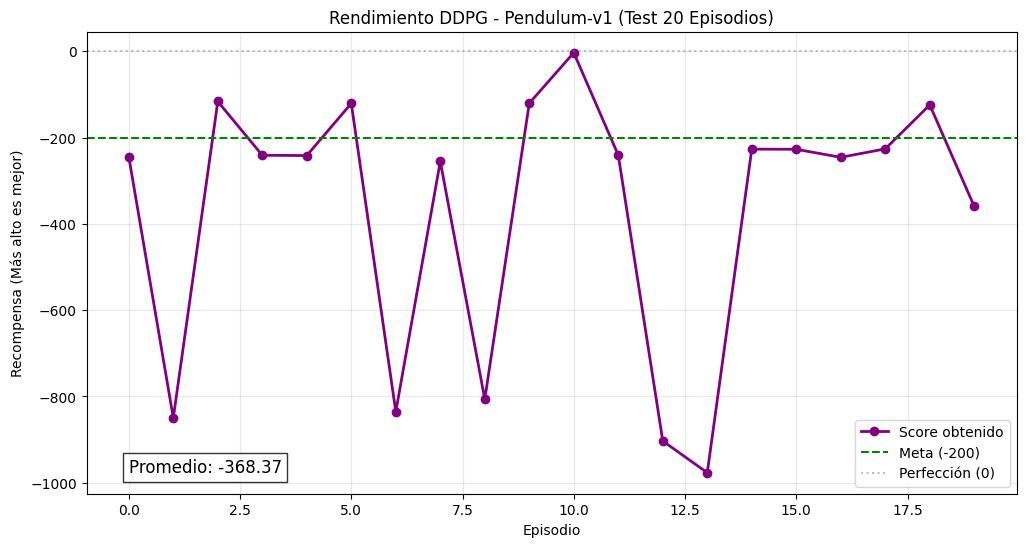

In [14]:
# --- 5. VISUALIZACIÓN GRÁFICA ---
plt.figure(figsize=(12, 6))

# Línea de rendimiento
plt.plot(scores, marker='o', linestyle='-', color='purple', linewidth=2, label='Score obtenido')

# Línea de referencia "Resuelto"
plt.axhline(y=-200, color='green', linestyle='--', label='Meta (-200)')

# Línea de perfección teórica
plt.axhline(y=0, color='gray', linestyle=':', alpha=0.5, label='Perfección (0)')

plt.title(f'Rendimiento DDPG - {env_name} (Test 20 Episodios)')
plt.xlabel('Episodio')
plt.ylabel('Recompensa (Más alto es mejor)')
plt.legend()
plt.grid(True, alpha=0.3)

# Mostrar estadísticas en la gráfica
avg_score = np.mean(scores)
plt.text(0, min(scores), f'Promedio: {avg_score:.2f}', fontsize=12,
         bbox=dict(facecolor='white', alpha=0.8))

plt.show()